In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from typing import List, Tuple, Dict, Optional
import gym
from gym import spaces
from scipy import ndimage

class WoodCuttingEnv(gym.Env):
    def __init__(self, big_platform_size=(100, 100), max_platforms=5):
        super(WoodCuttingEnv, self).__init__()
        
        # Initialize with the size of big wood platforms
        self.big_platform_width, self.big_platform_height = big_platform_size
        self.max_platforms = max_platforms
        
        # State: Representation of the current platform's state
        # We'll represent it as a binary grid
        self.grid_size = 100  # We'll use a 100x100 grid for simplicity
        

        #################################################################################
        # Track piece types in each position (0 = empty, 1+ = piece type index + 1)
        self.platforms = [np.zeros((self.grid_size, self.grid_size), dtype=np.int8)]
        self.piece_types = [np.zeros((self.grid_size, self.grid_size), dtype=np.int8)]
        #################################################################################


        # State space: Current platform's grid state + remaining order pieces + current platform index
        grid_space = spaces.Box(low=0, high=1, shape=(self.grid_size, self.grid_size), dtype=np.int8)
        
        # Max number of different piece types in an order
        self.max_order_types = 10
        # Order space: (width, height, quantity) for each order type
        order_space = spaces.Box(
            low=np.array([[1, 1, 0]] * self.max_order_types),
            high=np.array([[self.big_platform_width, self.big_platform_height, 100]] * self.max_order_types),
            dtype=np.int32
        )
        
        # Current platform index
        platform_index_space = spaces.Discrete(self.max_platforms + 1)  # +1 for "no platforms left"
        
        # Combine spaces
        self.observation_space = spaces.Dict({
            'grid': grid_space,
            'order': order_space,
            'platform_index': platform_index_space
        })
        
        # Action space: (x, y, piece_type, rotation)
        # x, y: position to place the piece
        # piece_type: which piece type from the order to use
        # rotation: 0 or 1 (0° or 90°)
        self.action_space = spaces.MultiDiscrete([
            self.grid_size,  # x
            self.grid_size,  # y
            self.max_order_types,  # piece_type
            2  # rotation (0 or 1)
        ])
        
        # Initialize state
        self.reset()
    
    def reset(self, order=None):
        """Reset environment with a new or provided order."""

        #################################################################################
        # Initialize the first platform grid (0 = empty, 1 = filled)
        self.platforms = [np.zeros((self.grid_size, self.grid_size), dtype=np.int8)]
        self.piece_types = [np.zeros((self.grid_size, self.grid_size), dtype=np.int8)]
        #################################################################################

        # # Initialize the first platform grid (0 = empty, 1 = filled)
        # self.platforms = [np.zeros((self.grid_size, self.grid_size), dtype=np.int8)]

        self.current_platform_idx = 0
        
        
        # Generate a random order if none provided
        if order is None:
            self.order = self._generate_random_order()
        else:
            self.order = order.copy()
        
        return self._get_observation()
    
    def _generate_random_order(self):
        """Generate a random cutting order."""
        num_types = np.random.randint(1, self.max_order_types + 1)
        order = []
        
        for _ in range(num_types):
            width = np.random.randint(5, min(self.big_platform_width // 2, 30) + 1)
            height = np.random.randint(5, min(self.big_platform_height // 2, 30) + 1)
            quantity = np.random.randint(1, 20)
            order.append([width, height, quantity])
        
        # Pad the order to max_order_types
        while len(order) < self.max_order_types:
            order.append([0, 0, 0])
            
        return np.array(order)
    
    def _get_observation(self):
        """Return the current observation."""
        return {
            'grid': self.platforms[self.current_platform_idx],
            'order': self.order,
            'platform_index': self.current_platform_idx
        }
    
    def _is_valid_placement(self, x, y, piece_width, piece_height, platform_idx=None):
        """Check if a piece can be placed at (x, y) with given dimensions."""
        if platform_idx is None:
            platform_idx = self.current_platform_idx
            
        if x + piece_width > self.grid_size or y + piece_height > self.grid_size:
            return False
        
        # Check if the area is empty
        if np.any(self.platforms[platform_idx][y:y+piece_height, x:x+piece_width] == 1):
            return False
        
        return True
    
    def _can_fit_anywhere(self, piece_width, piece_height, platform_idx=None):
        """
        Check if a piece can fit anywhere on the specified platform.
        If platform_idx is None, check the current platform.
        Returns (can_fit, (platform_idx, x, y)) if fit is possible.
        """
        if platform_idx is None:
            platforms_to_check = [self.current_platform_idx]
        else:
            platforms_to_check = [platform_idx]
            
        for platform_idx in platforms_to_check:
            for y in range(self.grid_size - piece_height + 1):
                for x in range(self.grid_size - piece_width + 1):
                    if self._is_valid_placement(x, y, piece_width, piece_height, platform_idx):
                        return True, (platform_idx, x, y)
        return False, None
    
    #################################################################################
    def _place_piece(self, x, y, piece_width, piece_height, piece_type, platform_idx=None):
    #################################################################################
    # def _place_piece(self, x, y, piece_width, piece_height, platform_idx=None):
        """Place a piece at (x, y) with given dimensions."""
        if platform_idx is None:
            platform_idx = self.current_platform_idx
            
        self.platforms[platform_idx][y:y+piece_height, x:x+piece_width] = 1

        #################################################################################
        self.piece_types[platform_idx][y:y+piece_height, x:x+piece_width] = piece_type + 1  # +1 to avoid 0
        #################################################################################

    def _can_fit_on_any_platform(self, piece_width, piece_height):
        """
        Check if a piece can fit on any existing platform.
        Returns (can_fit, (platform_idx, x, y)) if fit is possible.
        """
        # Check all existing platforms
        for platform_idx in range(len(self.platforms)):
            can_fit, position = self._can_fit_anywhere(piece_width, piece_height, platform_idx)
            if can_fit:
                return True, position
        return False, None

    def step(self, action):
        """
        Take a step in the environment.
        
        Args:
            action: [x, y, piece_type, rotation]
        
        Returns:
            observation, reward, done, info
        """
        x, y, piece_type, rotation = action
        
        # Check if piece_type is valid
        if piece_type >= len(self.order) or self.order[piece_type][2] <= 0:
            # Invalid piece type or no more pieces of this type
            return self._get_observation(), -10, False, {'message': 'Invalid piece type'}
        
        # Get piece dimensions
        width, height, quantity = self.order[piece_type]
        
        # Apply rotation if needed
        if rotation == 1:
            width, height = height, width
        
        # Check if placement is valid at the chosen position
        if not self._is_valid_placement(x, y, width, height):
            # First, check if the piece can fit anywhere else on the current platform
            can_fit_current, current_pos = self._can_fit_anywhere(width, height)
            
            if can_fit_current:
                # Place at the new position on current platform
                platform_idx, x, y = current_pos
                self._place_piece(x, y, width, height, piece_type, platform_idx)
                self.order[piece_type][2] -= 1
                reward = width * height - 5  # Small penalty for repositioning on same platform
                
            else:
                # Check if the piece can fit on any existing platform
                can_fit_existing, best_pos = self._can_fit_on_any_platform(width, height)
                
                if can_fit_existing:
                    # Place on an existing platform
                    platform_idx, x, y = best_pos
                    self._place_piece(x, y, width, height, piece_type, platform_idx)
                    self.current_platform_idx = platform_idx  # Update current platform
                    self.order[piece_type][2] -= 1
                    reward = width * height - 10  # Penalty for switching platforms
                    
                else:
                    # Try creating a new platform if none of the existing ones can fit the piece
                    if self.current_platform_idx + 1 < self.max_platforms:
                        # Create new platform if needed
                        if len(self.platforms) <= self.current_platform_idx + 1:
                            self.platforms.append(np.zeros((self.grid_size, self.grid_size), dtype=np.int8))
                            self.piece_types.append(np.zeros((self.grid_size, self.grid_size), dtype=np.int8))
                        
                        # Move to the new platform
                        self.current_platform_idx += 1
                        
                        # Try to place at (0,0) on new platform
                        if self._is_valid_placement(0, 0, width, height):
                            self._place_piece(0, 0, width, height, piece_type)
                            self.order[piece_type][2] -= 1
                            reward = width * height - 50  # Penalty for creating new platform
                        else:
                            reward = -20  # Penalty for invalid placement even on new platform
                    else:
                        reward = -30  # No more platforms available
                        return self._get_observation(), reward, True, {'message': 'No more platforms'}
        else:
            # Place the piece at the original position
            self._place_piece(x, y, width, height, piece_type)
            self.order[piece_type][2] -= 1
            reward = width * height  # Reward proportional to the piece area
        
        # Check if all pieces have been placed
        done = np.all(self.order[:, 2] == 0)
        
        # Calculate total waste (empty space) on used platforms
        if done:
            # Count how many platforms were actually used
            used_platforms = 0
            for platform in self.platforms:
                if np.any(platform == 1):
                    used_platforms += 1
            
            total_area = self.big_platform_width * self.big_platform_height * used_platforms
            filled_area = sum(np.sum(platform) for platform in self.platforms)
            waste = total_area - filled_area
            efficiency = filled_area / total_area
            
            # Add final reward based on efficiency
            reward += efficiency * 1000
            
            return self._get_observation(), reward, done, {
                'message': 'All pieces placed',
                'waste': waste,
                'efficiency': efficiency,
                'platforms_used': used_platforms
            }
        
        return self._get_observation(), reward, done, {}
    
    def render(self):
        # """Render the current state of the environment."""
        """Render the current state of the environment with different colors for each piece type."""
        piece_colors = ['white', 'red', 'blue', 'green', 'purple', 'orange', 'yellow', 'black', 'gray', 'pink', 'brown']

        #################################################################################

        fig, axs = plt.subplots(1, len(self.platforms), figsize=(5*len(self.platforms), 5))
        if len(self.platforms) == 1:
            axs = [axs]
        
        for i, platform in enumerate(self.platforms):
            ax = axs[i]
            
            # Create a colored image
            colored_image = np.zeros((self.grid_size, self.grid_size, 3))
            
            # Fill with colors based on piece types
            for y in range(self.grid_size):
                for x in range(self.grid_size):
                    piece_type = self.piece_types[i][y, x]
                    if piece_type > 0:
                        # Convert color name to RGB
                        color_name = piece_colors[piece_type]
                        color_rgb = np.array(plt.matplotlib.colors.to_rgb(color_name))
                        colored_image[y, x] = color_rgb
            
            ax.imshow(colored_image)
            ax.set_title(f'Platform {i+1}')
            ax.set_xlim(0, self.grid_size)
            ax.set_ylim(0, self.grid_size)
            ax.invert_yaxis()  # Invert y-axis to match grid coordinates
            
            # Draw grid lines
            # Add grid lines (optional, for clarity)
            # ax.set_xticks(np.arange(-.5, self.grid_size, 10))
            # ax.set_yticks(np.arange(-.5, self.grid_size, 10))
            ax.grid(True, color='black', linewidth=0.5, alpha=0.3)
            
            # Add piece outlines
            for type_id in range(1, self.max_order_types + 1):
                piece_mask = (self.piece_types[i] == type_id)
                if not np.any(piece_mask):
                    continue
                    
                # Find connected components
                labeled, num_features = ndimage.label(piece_mask)
                
                for feature in range(1, num_features + 1):
                    feature_mask = (labeled == feature)
                    
                    # Get the bounds of this feature
                    ys, xs = np.where(feature_mask)
                    # x_min, x_max = np.min(xs), np.max(xs)
                    # y_min, y_max = np.min(ys), np.max(ys)
                    
                    # Draw rectangle around the piece
                    # rect = patches.Rectangle(
                    #     (x_min - 0.5, y_min - 0.5), 
                    #     x_max - x_min + 1, 
                    #     y_max - y_min + 1, 
                    #     linewidth=2, 
                    #     edgecolor='black', 
                    #     facecolor='none'
                    # )
                    # ax.add_patch(rect)
        
        # Display remaining order with colors
        order_text = []
        for idx, (w, h, q) in enumerate(self.order):
            if q > 0:
                color = piece_colors[idx + 1]
                order_text.append(f"<span style='color:{color}'>{w}x{h} (qty: {q})</span>")
        
        if order_text:
            from matplotlib.text import Text
            plt.figtext(0.5, 0.01, f"Remaining pieces: {', '.join(order_text)}", 
                    ha="center", fontsize=9, bbox={"facecolor":"white", "alpha":0.8})
        else:
            plt.figtext(0.5, 0.01, "All pieces placed!", ha="center", fontsize=9, 
                    bbox={"facecolor":"green", "alpha":0.5})
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.show()
        
    def close(self):
        plt.close('all')

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random

class DQNNetwork(nn.Module):
    def __init__(self, input_shape, output_size):
        super(DQNNetwork, self).__init__()
        
        # CNN for processing the grid
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        
        # Calculate the size after convolutions
        def conv2d_size_out(size, kernel_size=3, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        
        conv_width = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[1], 5, 2)))
        conv_height = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[0], 5, 2)))
        linear_input_size = conv_width * conv_height * 64
        
        # FC for processing the order information
        self.fc_order = nn.Linear(30, 128)  # 10 order types x 3 features (width, height, quantity)
        
        # FC for processing platform index
        self.fc_platform = nn.Linear(1, 32)
        
        # Combine and process
        self.fc_combine = nn.Linear(linear_input_size + 128 + 32, 512)
        self.fc_advantage = nn.Linear(512, output_size)
        self.fc_value = nn.Linear(512, 1)
        
    def forward(self, grid, order, platform_idx):
        # Process grid
        grid = grid.unsqueeze(1)  # Add channel dimension
        grid = F.relu(self.conv1(grid))
        grid = F.relu(self.conv2(grid))
        grid = F.relu(self.conv3(grid))
        grid = grid.view(grid.size(0), -1)  # Flatten
        
        # Process order
        order = order.view(order.size(0), -1)  # Flatten
        order = F.relu(self.fc_order(order))
        
        # Process platform index
        platform_idx = platform_idx.float().view(-1, 1)
        platform = F.relu(self.fc_platform(platform_idx))
        
        # Combine
        combined = torch.cat((grid, order, platform), dim=1)
        features = F.relu(self.fc_combine(combined))
        
        # Dueling DQN architecture
        advantage = self.fc_advantage(features)
        value = self.fc_value(features)
        
        # Combine value and advantage
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        
        return q_values

class DQNAgent:
    def __init__(self, state_shape, action_space, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.state_shape = state_shape
        self.action_space = action_space
        self.device = device
        
        # DQN hyperparameters
        self.gamma = 0.99  # Discount factor
        self.learning_rate = 0.0001
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.memory = deque(maxlen=10000)
        
        # Create Q networks (main and target)
        self.q_network = DQNNetwork(
            input_shape=(state_shape['grid'][0], state_shape['grid'][1]),
            output_size=action_space[0] * action_space[1] * action_space[2] * action_space[3]
        ).to(device)
        
        self.target_network = DQNNetwork(
            input_shape=(state_shape['grid'][0], state_shape['grid'][1]),
            output_size=action_space[0] * action_space[1] * action_space[2] * action_space[3]
        ).to(device)
        
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        
        # For handling actions
        self.grid_size = state_shape['grid'][0]
        self.max_order_types = state_shape['order'][0]
        self.rotations = action_space[3]
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state, training=True):
        # Random exploration during training
        if training and np.random.rand() <= self.epsilon:
            # Random action but only for valid piece types
            valid_piece_types = [i for i, (_, _, qty) in enumerate(state['order']) if qty > 0]
            if not valid_piece_types:
                # No valid pieces left
                return [0, 0, 0, 0]  # Return dummy action
                
            piece_type = np.random.choice(valid_piece_types)
            x = np.random.randint(0, self.action_space[0])
            y = np.random.randint(0, self.action_space[1])
            rotation = np.random.randint(0, self.action_space[3])
            return [x, y, piece_type, rotation]
        
        # Convert state to tensors
        grid = torch.FloatTensor(state['grid']).unsqueeze(0).to(self.device)
        order = torch.FloatTensor(state['order']).unsqueeze(0).to(self.device)
        platform_idx = torch.LongTensor([state['platform_index']]).to(self.device)
        
        # Get Q values
        with torch.no_grad():
            q_values = self.q_network(grid, order, platform_idx)
            q_values = q_values.view(
                self.grid_size, 
                self.grid_size, 
                self.max_order_types, 
                self.rotations
            )
        
        # Create a mask for invalid piece types
        mask = np.ones_like(q_values.cpu().numpy()) * float('-inf')
        for i, (_, _, qty) in enumerate(state['order']):
            if qty > 0:
                mask[:, :, i, :] = 0  # Set to 0 for valid piece types
        
        # Apply the mask to Q values
        q_values_np = q_values.cpu().numpy()
        masked_q_values = q_values_np + mask
        
        # Choose best action from masked Q values
        action_flat = np.argmax(masked_q_values.flatten())
        
        # Convert flat index to multi-dimensional action
        indices = np.unravel_index(action_flat, q_values_np.shape)
        return list(indices)
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample a batch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        
        # Prepare batch data
        grids = torch.FloatTensor(np.array([s['grid'] for s, _, _, _, _ in minibatch])).to(self.device)
        orders = torch.FloatTensor(np.array([s['order'] for s, _, _, _, _ in minibatch])).to(self.device)
        platform_idxs = torch.LongTensor(np.array([s['platform_index'] for s, _, _, _, _ in minibatch])).to(self.device)
        
        next_grids = torch.FloatTensor(np.array([s['grid'] for _, _, _, s, _ in minibatch])).to(self.device)
        next_orders = torch.FloatTensor(np.array([s['order'] for _, _, _, s, _ in minibatch])).to(self.device)
        next_platform_idxs = torch.LongTensor(np.array([s['platform_index'] for _, _, _, s, _ in minibatch])).to(self.device)
        
        actions = np.array([a for _, a, _, _, _ in minibatch])
        rewards = torch.FloatTensor(np.array([r for _, _, r, _, _ in minibatch])).to(self.device)
        dones = torch.FloatTensor(np.array([d for _, _, _, _, d in minibatch])).to(self.device)
        
        # Compute current Q values
        current_q_values = self.q_network(grids, orders, platform_idxs)
        
        # Convert actions to flat indices for gathering
        action_indices = np.zeros(self.batch_size, dtype=np.int64)
        for i, action in enumerate(actions):
            x, y, piece_type, rotation = action
            action_indices[i] = (x * self.grid_size * self.max_order_types * self.rotations + 
                               y * self.max_order_types * self.rotations + 
                               piece_type * self.rotations + 
                               rotation)
        
        action_indices = torch.LongTensor(action_indices).to(self.device)
        current_q = current_q_values.gather(1, action_indices.unsqueeze(1)).squeeze(1)
        
        # Compute next Q values using Double DQN approach
        with torch.no_grad():
            # Get actions from main network
            next_q_main = self.q_network(next_grids, next_orders, next_platform_idxs)
            next_actions = next_q_main.max(1)[1]
            
            # Get Q values from target network for those actions
            next_q_target = self.target_network(next_grids, next_orders, next_platform_idxs)
            next_q = next_q_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
            
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss and update
        loss = F.smooth_l1_loss(current_q, target_q)  # Using Huber loss for stability
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def save_model(self, path):
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
    
    def load_model(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']

In [6]:
def custom_order_example():
    """Example of using a custom order."""
    # Create environment
    platform_width = 100
    platform_height = 100
    max_platforms = 5
    env = WoodCuttingEnv(
        big_platform_size=(platform_width, platform_height),
        max_platforms=max_platforms
    )
    # env = WoodCuttingEnv()
    
    # Create and load agent
    agent = DQNAgent(
        state_shape={
            'grid': env.observation_space['grid'].shape,
            'order': env.observation_space['order'].shape,
            'platform_index': (0,)
        },
        action_space=env.action_space.nvec
    )
    
    try:
        # agent.load_model('models/dqn_wood_cutting_final.pth')
        agent.load_model(r'/home/viettiev/projects/REL301m/my_assignment/deep_q_network_heuristic/models/dqn_wood_cutting_final.pth')
        print("Loaded trained model")
    except:
        print("No trained model found, using untrained agent")
    
    # You can define your custom order here
    # custom_order = np.array([
    #     [40, 30, 6],    # 6 pieces of 40x30  
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0],     # Padding
    #     [0, 0, 0]      # Padding
    # ])
    custom_order = np.array([
        [40, 40, 1],   # 1 pieces of 40x40  
        [60, 60, 2],   # 2 pieces of 60x60  
        [40, 30, 10],   # 10 pieces of 40x30  
        [20, 10, 9],     # 9 pieces of 20x10  
        [0, 0, 0],     # Padding
        [0, 0, 0],     # Padding
        [0, 0, 0],     # Padding
        [0, 0, 0],     # Padding
        [0, 0, 0],     # Padding
        [0, 0, 0]      # Padding
    ])
    
    # Reset environment with custom order
    state = env.reset(order=custom_order)
    # Run episode with custom order
    done = False
    total_reward = 0
    steps = 0
    max_steps = 50

    print('current_step: ',steps)
    env.render()
    
    print("Starting custom order optimization...")
    
    while not done and steps < max_steps:
        # Choose action
        action = agent.act(state, training=False)
        
        # Take action
        next_state, reward, done, info = env.step(action)
        # print(next_state, reward, done, info)
        # Update state and total reward
        state = next_state
        total_reward += reward
        steps += 1
        print('current_step: ',steps)
        env.render()
        if done:
            print(f"Order completed in {steps} steps")
            print(f"Total reward: {total_reward:.2f}")
            if 'waste' in info:
                print(f"Waste: {info['waste']}")
                print(f"Efficiency: {info['efficiency']:.2f}")
                print(f"Platforms used: {info['platforms_used']}")
    
    # Render final state
    print('current_step: ',steps)
    env.render()
    
    if not done:
        print(f"Failed to complete order within {max_steps} steps")
    
    return total_reward

Loaded trained model
current_step:  0


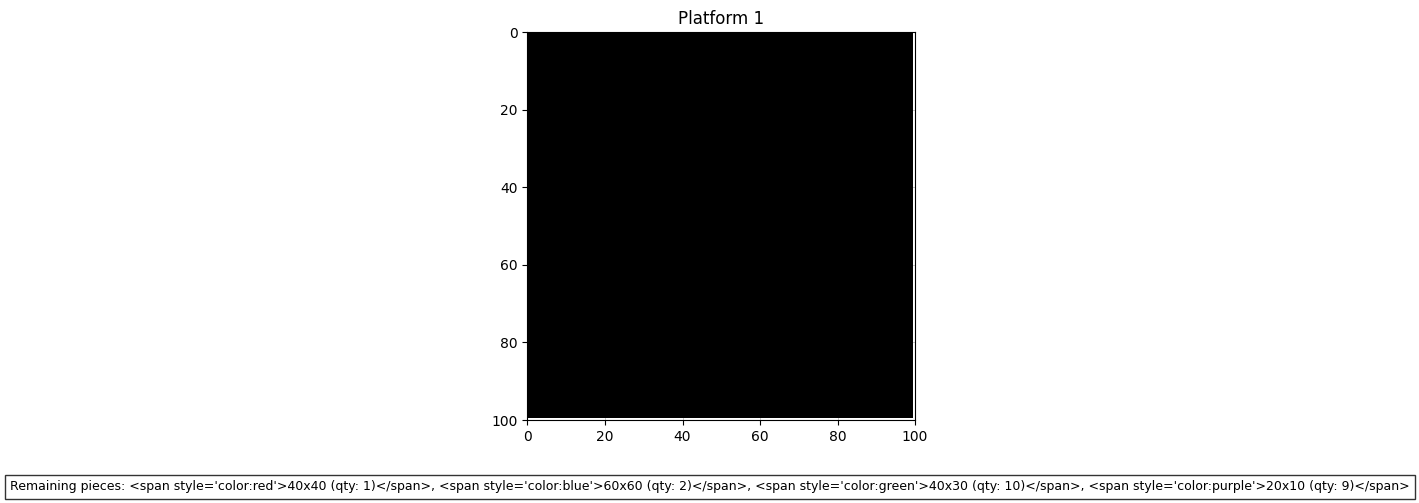

Starting custom order optimization...
current_step:  1


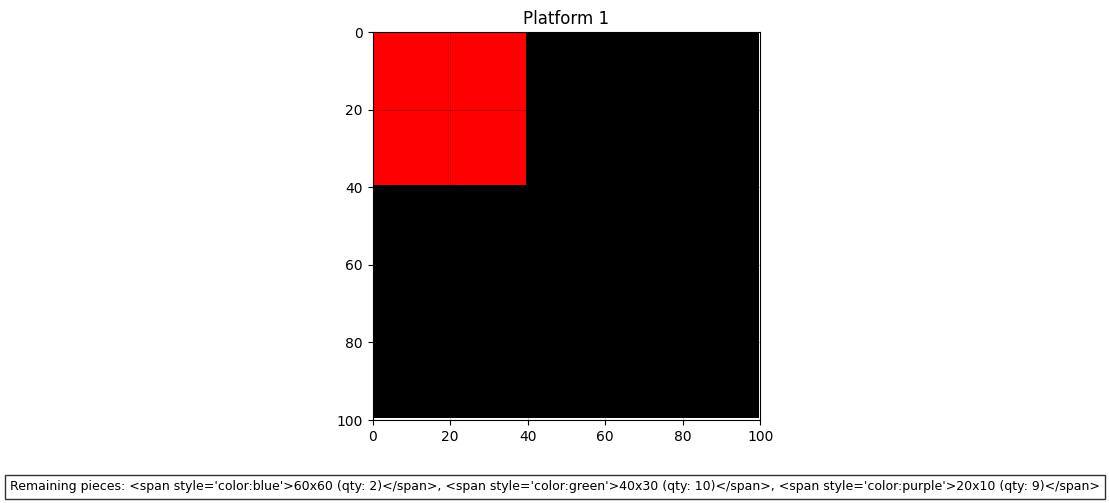

current_step:  2


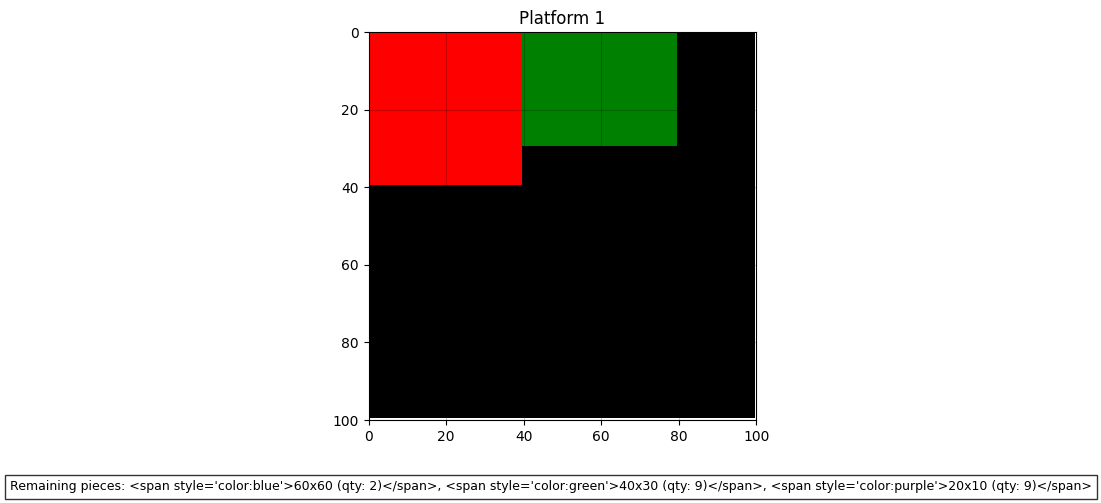

current_step:  3


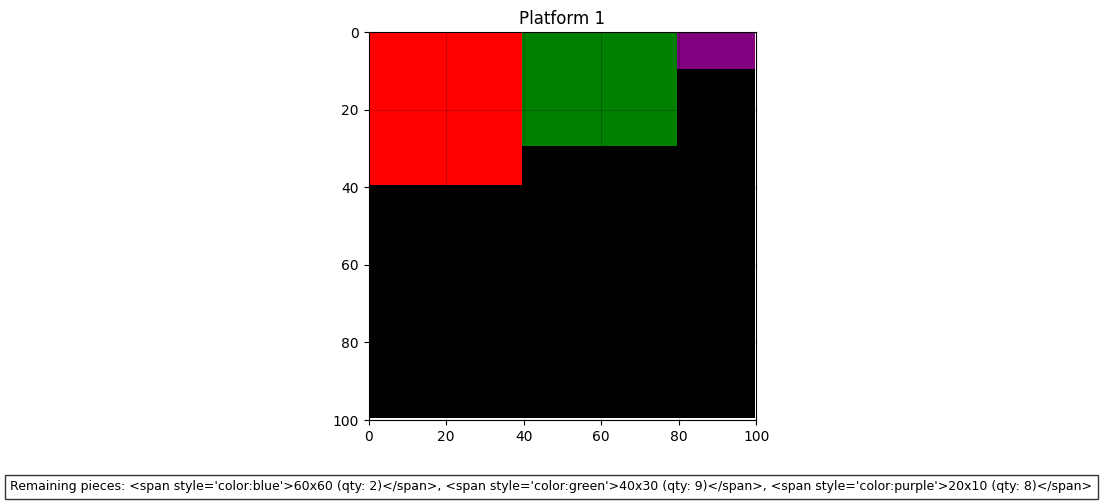

current_step:  4


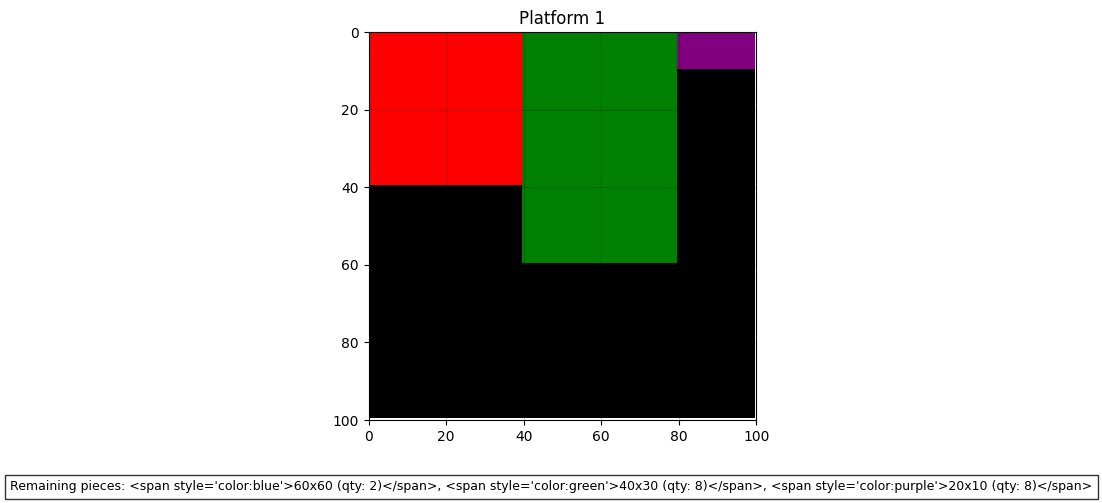

current_step:  5


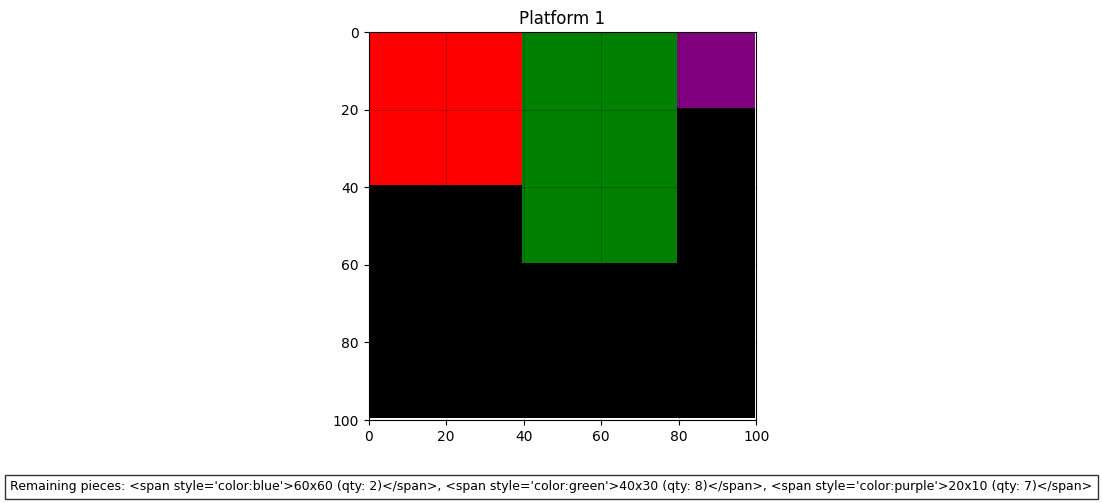

current_step:  6


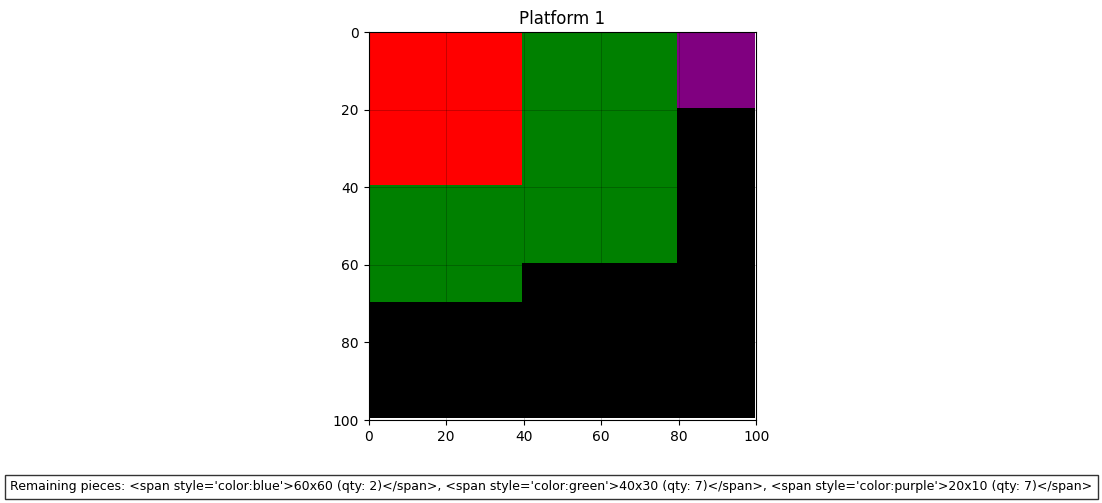

current_step:  7


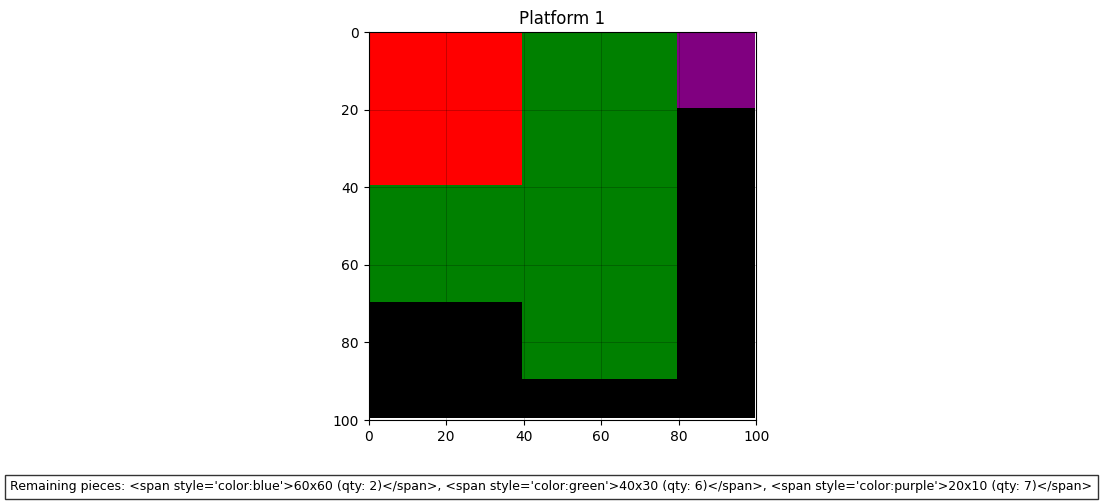

current_step:  8


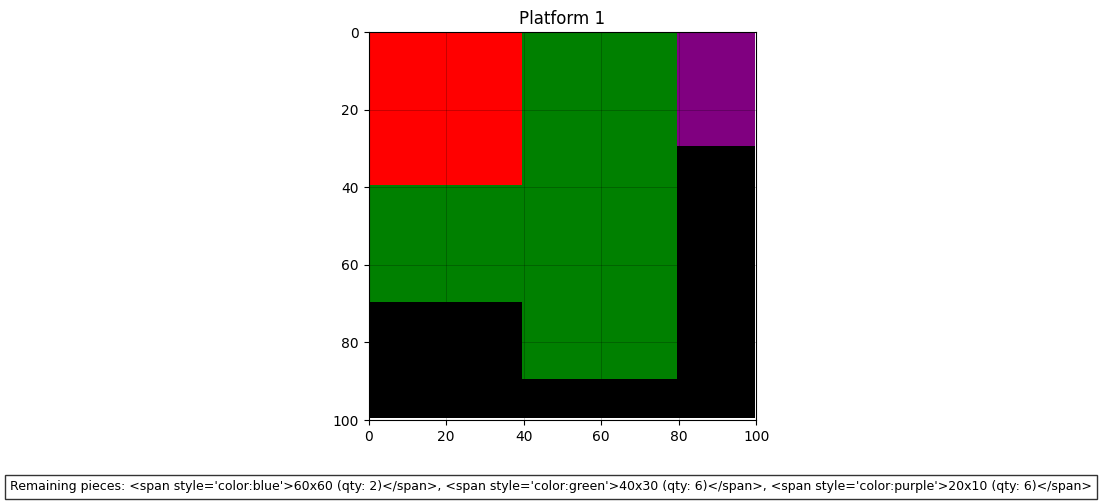

current_step:  9


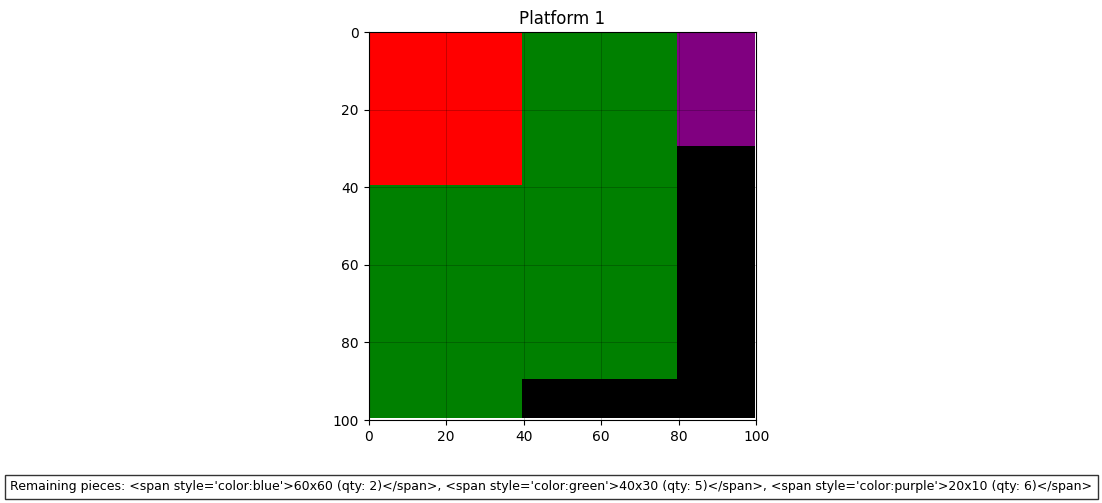

current_step:  10


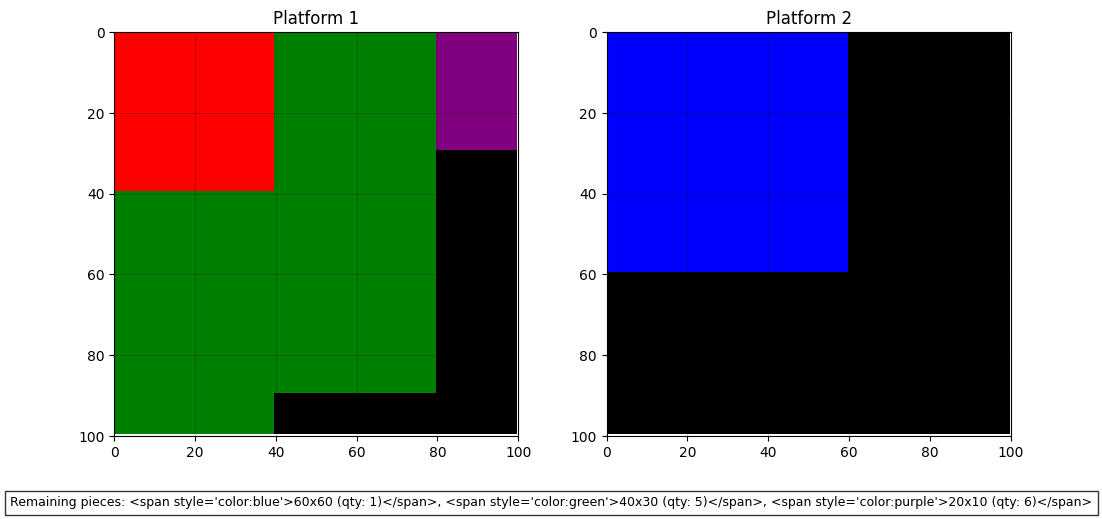

current_step:  11


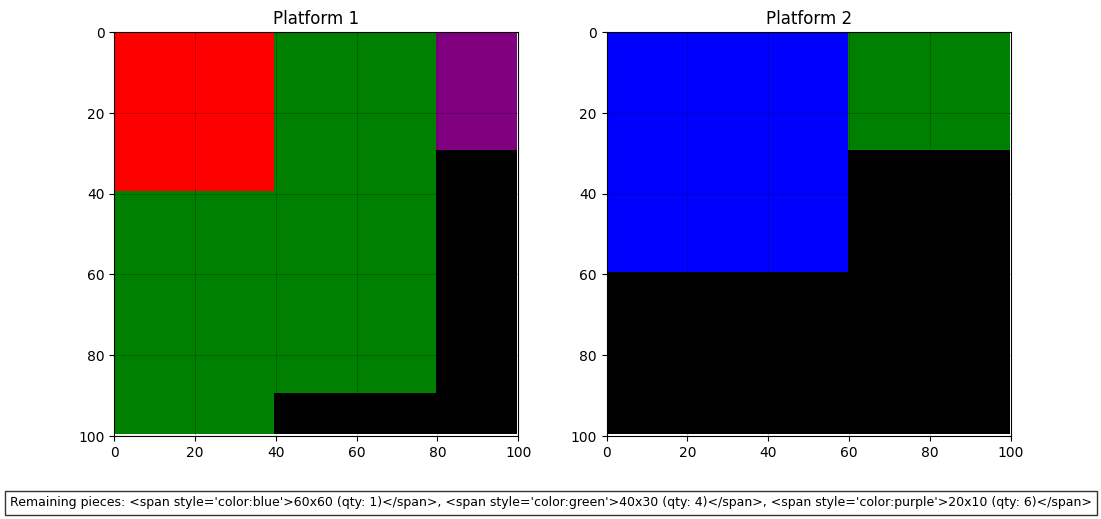

current_step:  12


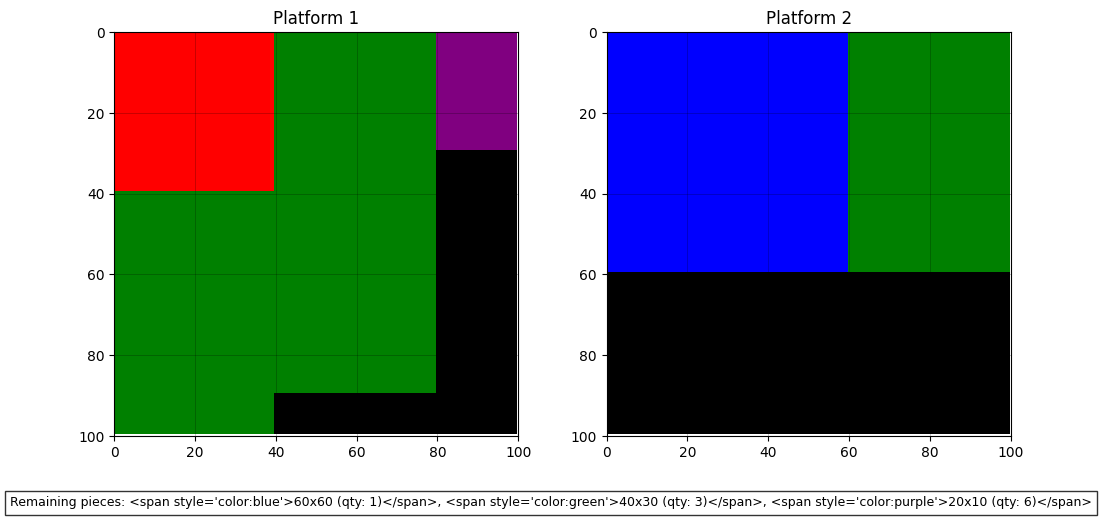

current_step:  13


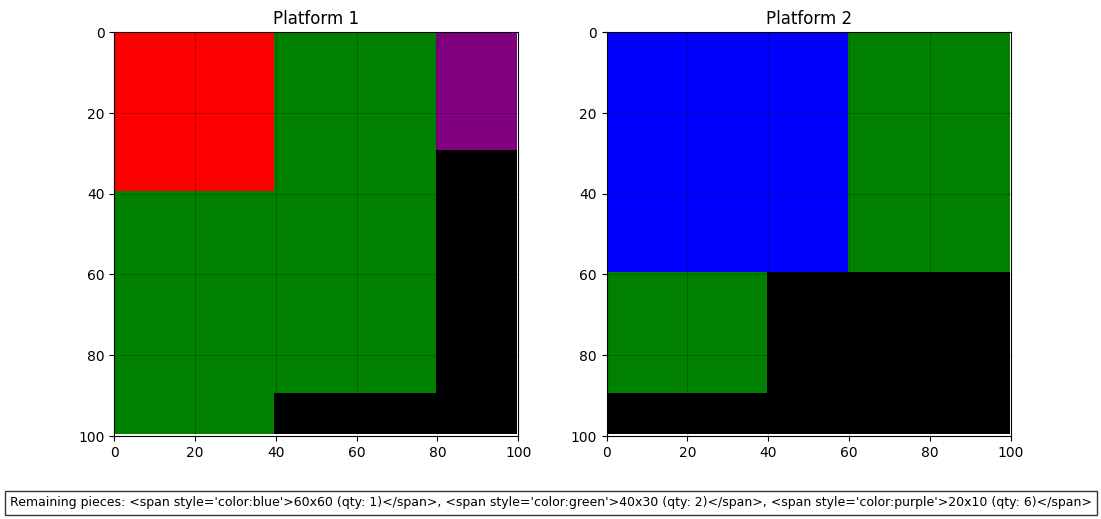

current_step:  14


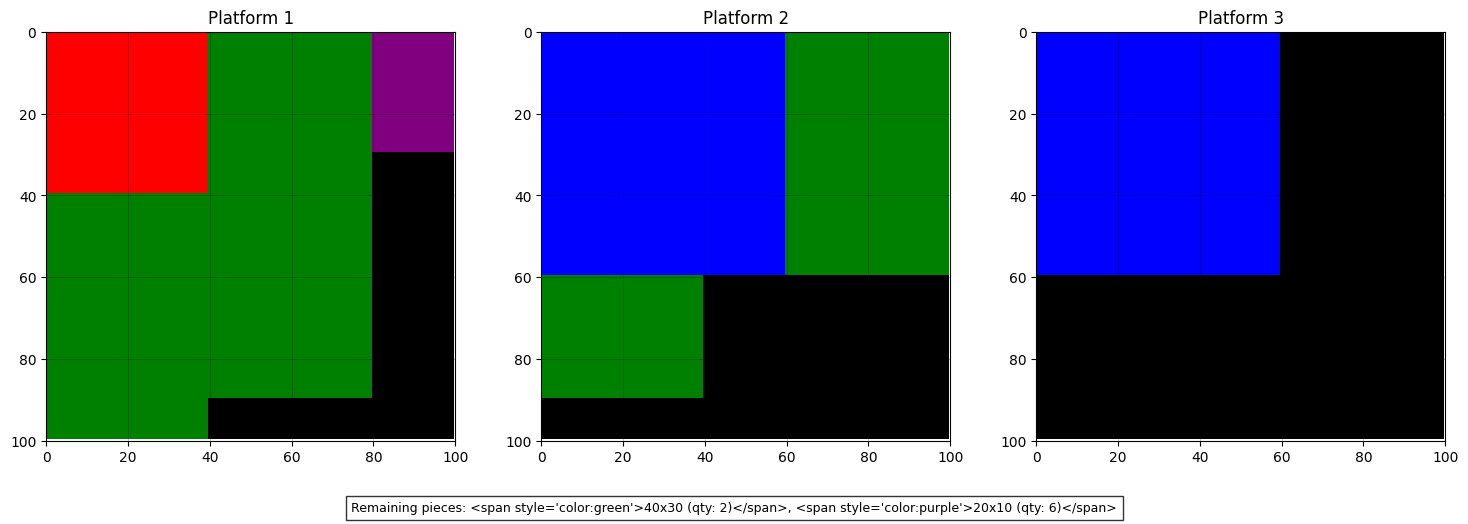

current_step:  15


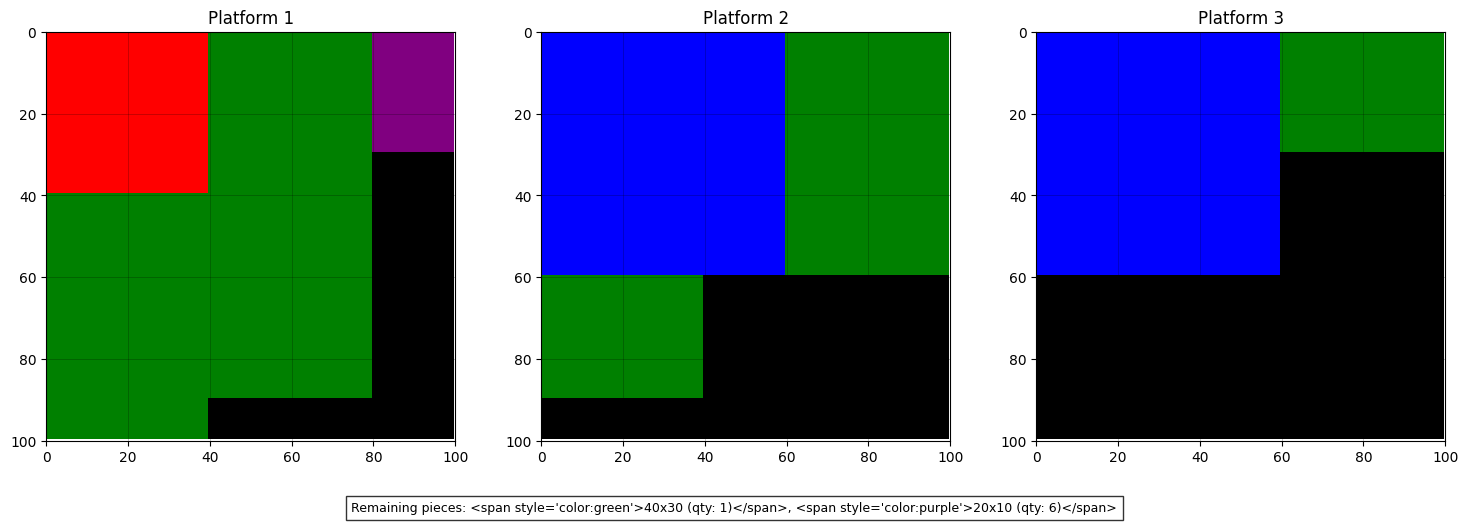

current_step:  16


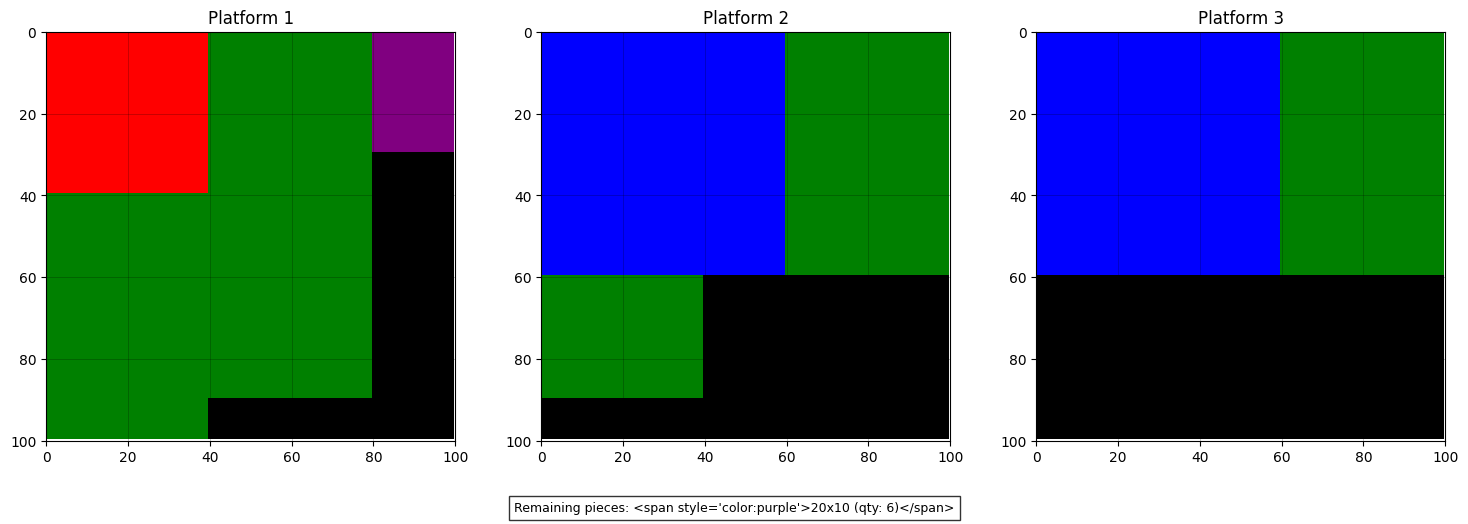

current_step:  17


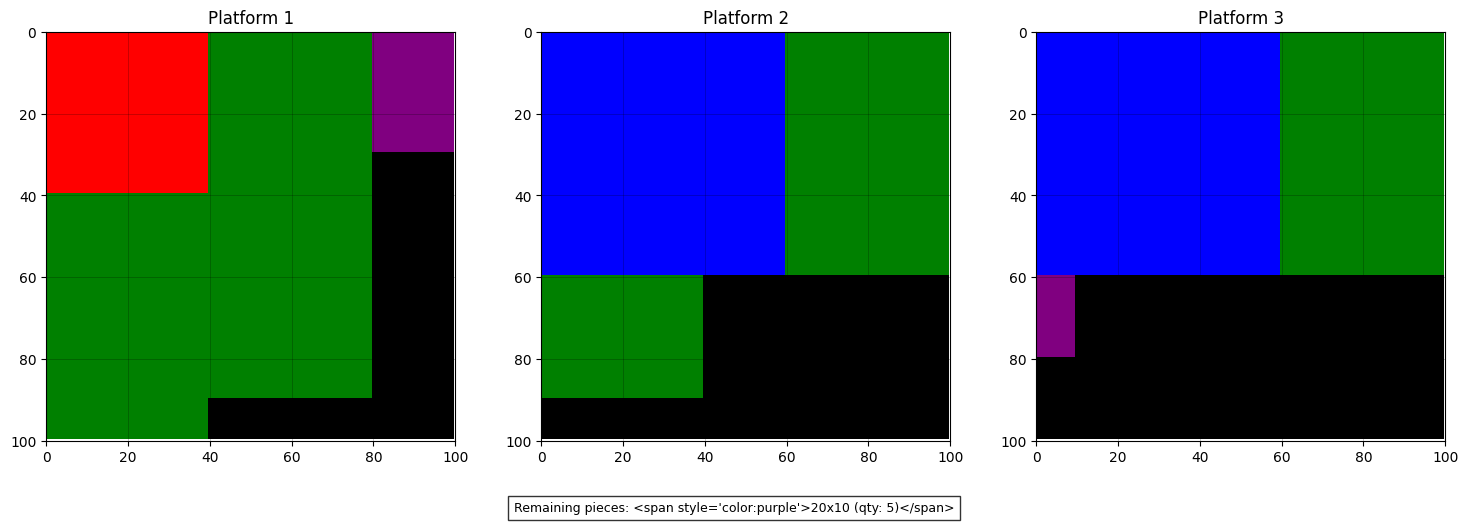

current_step:  18


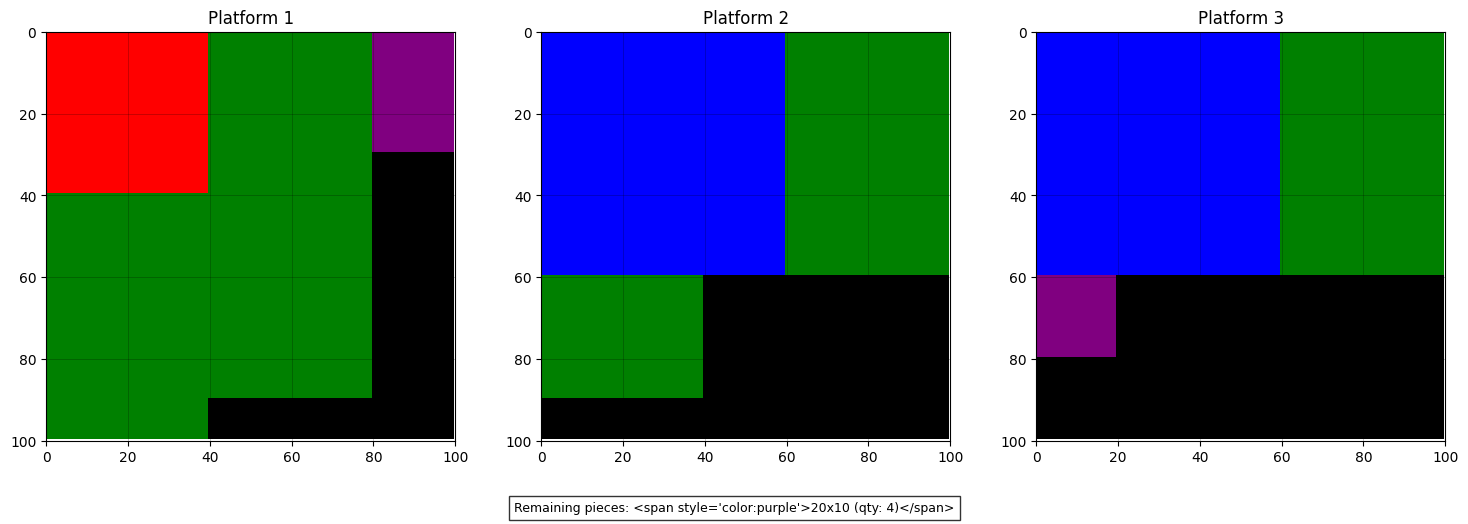

current_step:  19


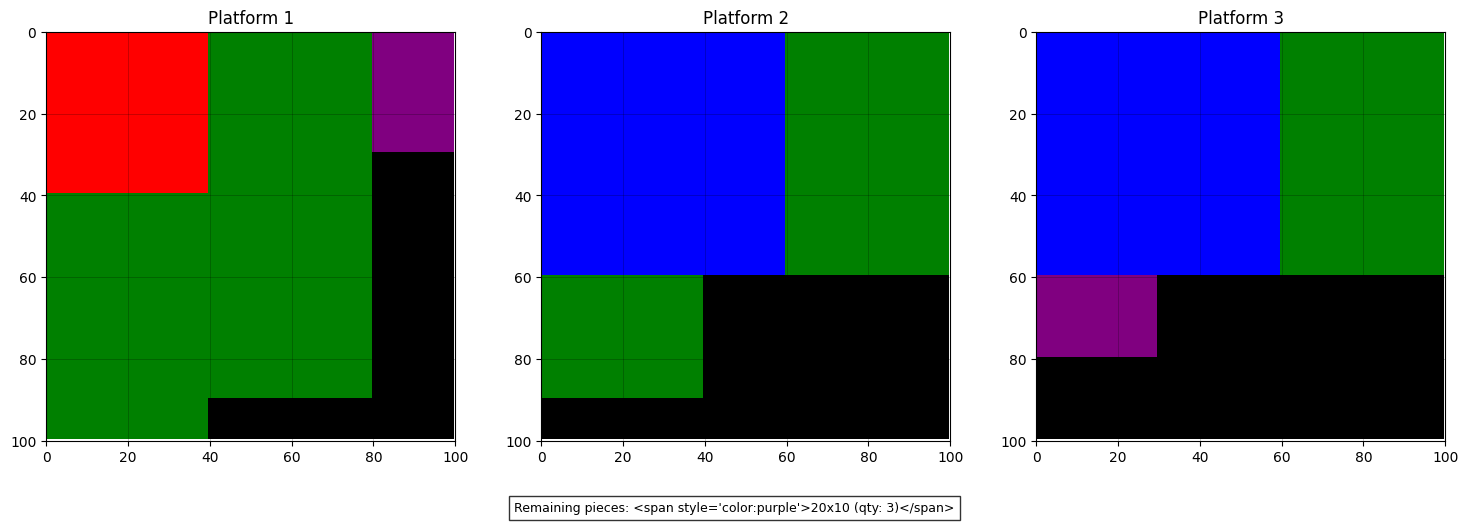

current_step:  20


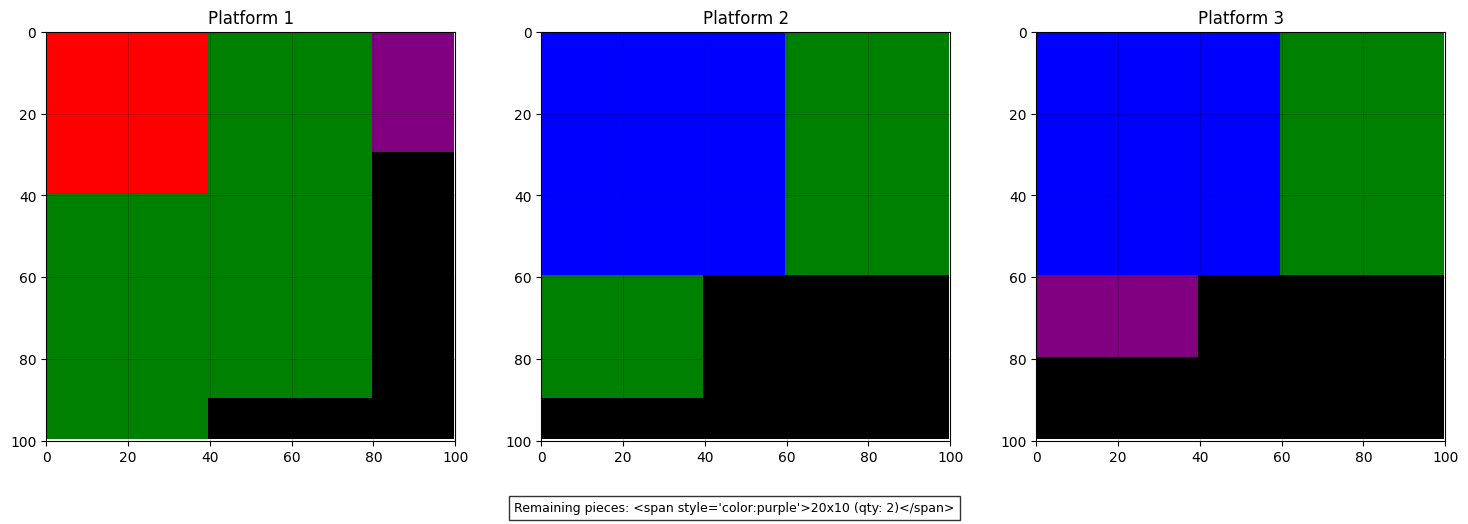

current_step:  21


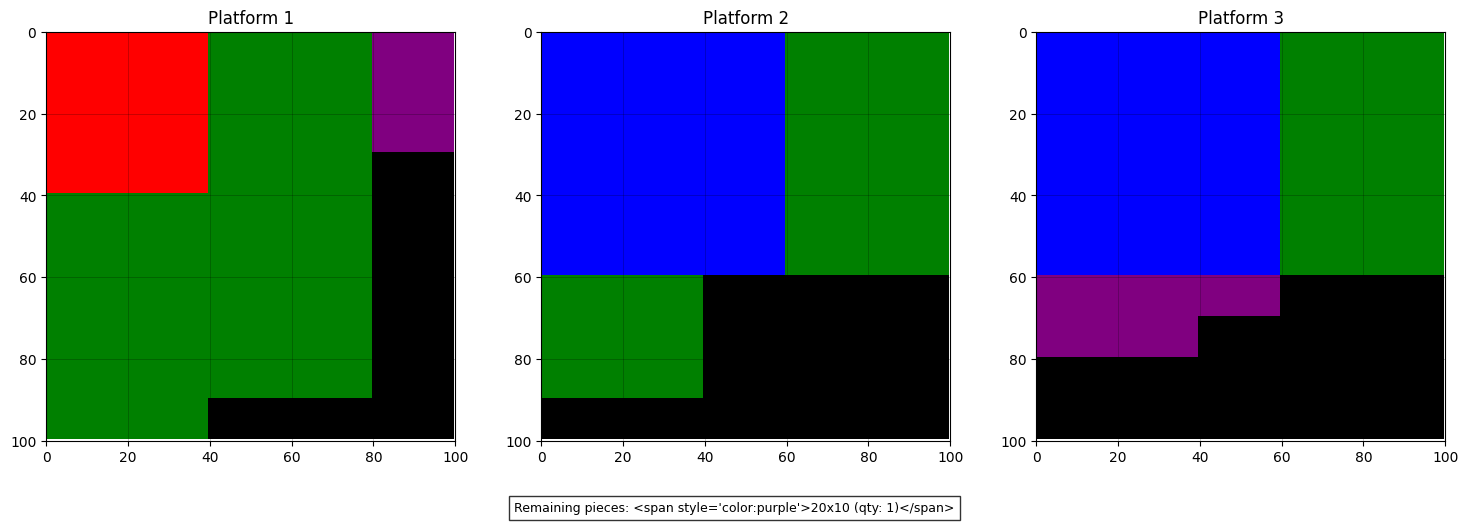

current_step:  22


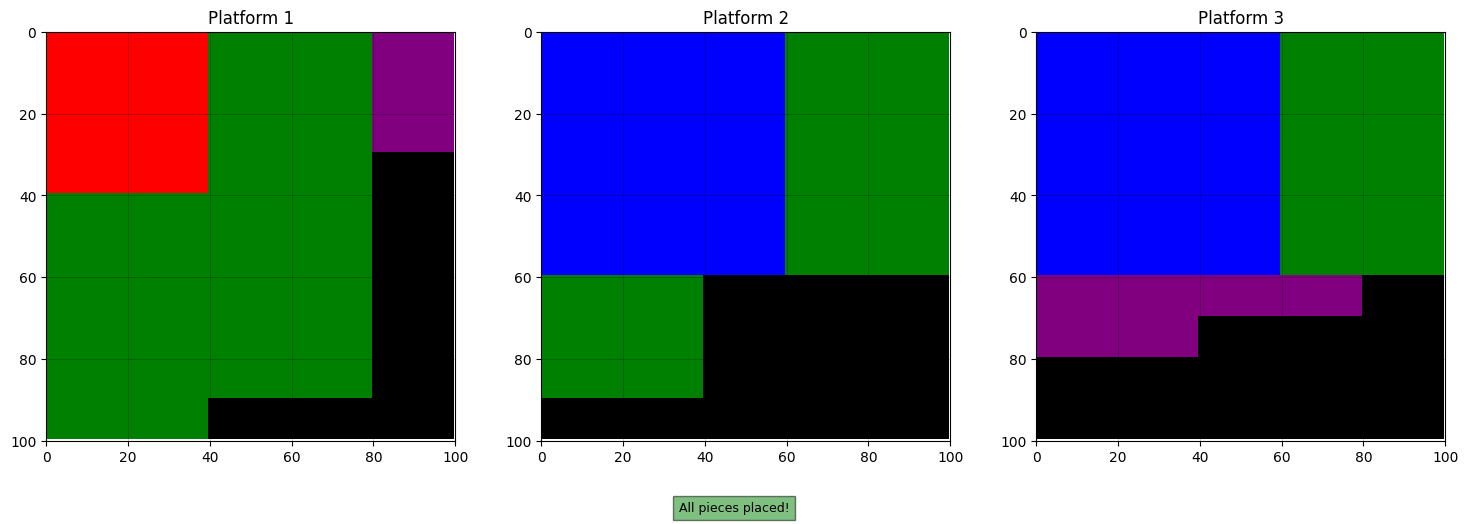

Order completed in 22 steps
Total reward: 23153.33
Waste: 7400
Efficiency: 0.75
Platforms used: 3
current_step:  22


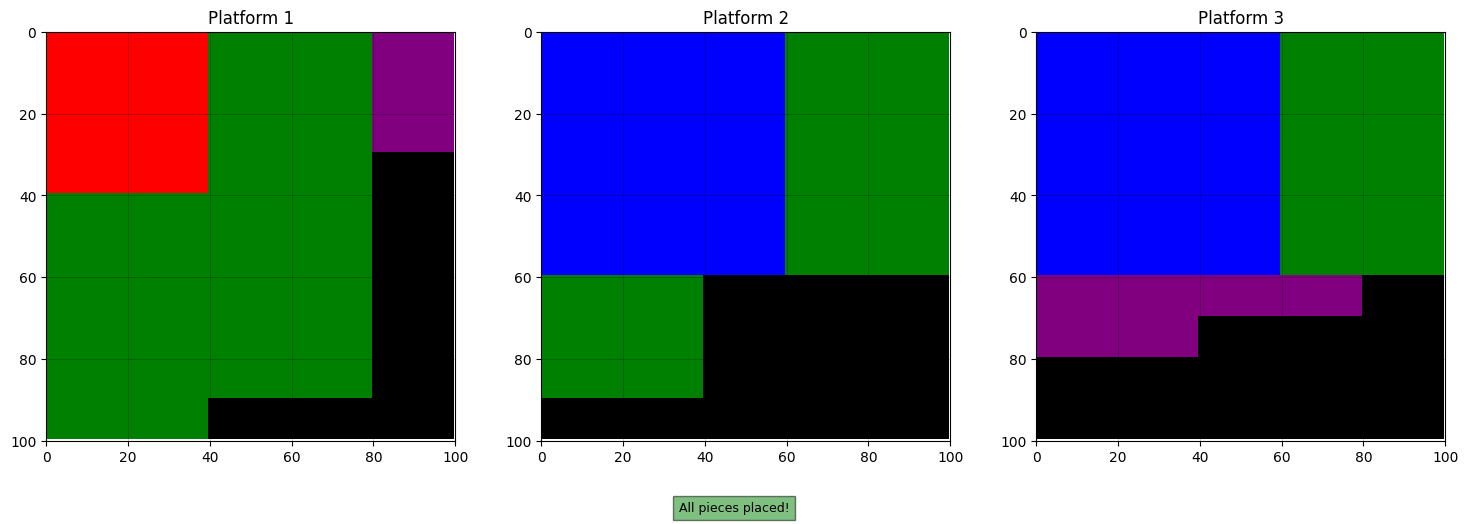

np.float64(23153.333333333332)

In [7]:
custom_order_example()